# compute 2PCF information content from limited halo catalogue

- data: halo catalogues stored as `jraph.GraphsTuple` objects

In [1142]:
import numpy as np
import astroML
import scipy
import jraph
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform,pdist,cdist

In [1143]:
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [1144]:
# halo data
fiducial = load_obj('halodata/fid.pkl')
validation_fiducial = load_obj('halodata/val_fid.pkl')

numerical_derivative = load_obj('halodata/derv.pkl')
validation_numerical_derivative = load_obj('halodata/val_derv.pkl')

# get halo masses into datasets for p(k) fisher calculation
fiducial = np.concatenate([fiducial.nodes, validation_fiducial.nodes], axis=0)

# ordering om, s8m, omp, s8p, ....
derv = np.concatenate([numerical_derivative.nodes, validation_numerical_derivative.nodes], axis=0)

In [30]:
n_s = 1000
n_d = 500
n_param = 2

θ_fid = np.array([0.3175, 0.834])
δθ = 2*np.array([0.01, 0.015])

θ_der = (θ_fid + np.einsum("i,jk->ijk", np.array([-1., 1.]), np.diag(δθ) / 2.)).reshape((-1, 2))

In [1097]:
# define function for assembling 2PCF tables
bins = np.linspace(0, 3**(1/3), num=10)
bins = np.concatenate([bins, [bins[2] - bins[1] + bins[-1]]])

def get_2PCF(dset, num, bins=bins):
    corrs = np.zeros((num, (len(bins)-1)**2)) # **2
    for i in range(num):
        points = dset[i, :, 4:][dset[i, :, 0] > 0.]
        _N = points.shape[0]
        d = squareform(pdist(points))
        r1 = np.tile(d.reshape((_N**2, 1)), _N).flatten()
        r2 = np.tile(d, _N).flatten()
        n, xedges, yedges = np.histogram2d(r1, r2, bins=[bins, bins])
        corrs[i, :] = n.flatten() 
        
    return corrs

In [ ]:
def get_2PCF(dset, num, r_connect, bins=10, fill=1000.):
    corrs = np.zeros((num, bins**2))
    for i in range(num):
        points = dset[i, :, 4:][dset[i, :, 0] > 0.]
        _N = points.shape[0]
        d = squareform(pdist(points))
        
        _N = d.shape[0]
        # take d < r_connect
        #d = d[d < r_connect]
        mask = (d > r_connect) # mask out bigger edges than r_connect
        d[mask] = fill
        
        r1 = np.tile(d.reshape((_N**2, 1)), _N).flatten()
        r1 = r1[r1 < fill]
        r2 = np.tile(d, _N).flatten()
        r2 = r2[r2 < fill]
        n, xedges, yedges = np.histogram2d(r1, r2, bins=bins)
        corrs[i, :] = n.flatten() #[:bins**2 // 2]#np.sort(n.flatten())

In [1098]:
%%time 
fid_corrs = get_2PCF(fiducial, 1000, bins=bins)
derv_corrs = get_2PCF(derv, 2000, bins=bins)

CPU times: user 1min 53s, sys: 20.8 s, total: 2min 14s
Wall time: 2min 16s


In [1099]:
_fid_corrs = fid_corrs
_derv_corrs = derv_corrs

In [788]:
fid_corrs = np.tril(_fid_corrs.reshape(1000, 10, 10) + eps, k=0)

In [1176]:
rshp = 55
eps = 1e-23

fid_corrs = np.tril(_fid_corrs.reshape(1000, 10, 10) + eps, k=0)
fid_corrs = fid_corrs[fid_corrs != 0].reshape(1000, -1)
fid_corrs = np.where(fid_corrs == eps, 0., fid_corrs)

derv_corrs = np.tril(_derv_corrs.reshape(2000, 10, 10) + eps, k=0) #.reshape(2000, 100)
derv_corrs = derv_corrs[derv_corrs != 0].reshape(2000, -1)

derv_corrs = np.where(derv_corrs == eps, 0., derv_corrs)

In [1177]:
derv_corrs.shape

(2000, 55)

Text(0.5, 0, 'index')

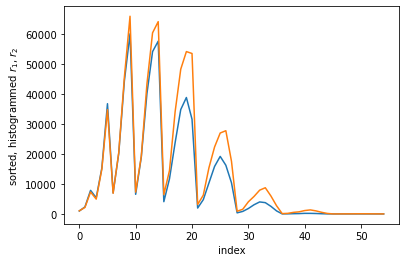

In [1178]:
# visualize flattened, sorted 2D histograms
plt.plot((fid_corrs[0].flatten()))
plt.plot((derv_corrs[0].flatten()))
plt.ylabel(r'sorted, histogrammed $r_1$, $r_2$')
plt.xlabel('index')

Text(0.5, 0, 'index')

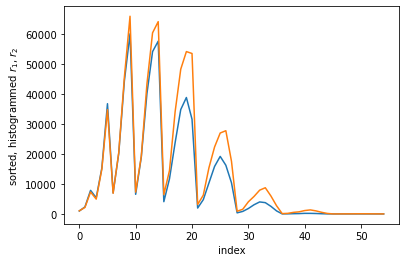

In [1179]:
plt.plot((fid_corrs[0].flatten()))
plt.plot((derv_corrs[0].flatten()))
plt.ylabel(r'sorted, histogrammed $r_1$, $r_2$')
plt.xlabel('index')

In [1180]:
# om-, s8-, om+, ...

In [1181]:
# get derivatives
δθ = 2*np.array([0.01, 0.015])

x_mp = derv_corrs.reshape(n_d, n_param, 2, derv_corrs.shape[-1])

# compute finite-differences for derivatives
_dervs = (x_mp[:, :, 1, :] - x_mp[:, :, 0, :]) / np.expand_dims(np.expand_dims(δθ, 0), -1) #np.swapaxes(x_mp[:, :, 1] - x_mp[:, :, 0], 1, 2) / δθ

# take mean
_dervs = np.mean(_dervs, axis=0)

# get covariance from fiducial sims
C = np.cov(fid_corrs.reshape(-1, fid_corrs.shape[-1]), rowvar=False)
invC = np.linalg.inv(C)

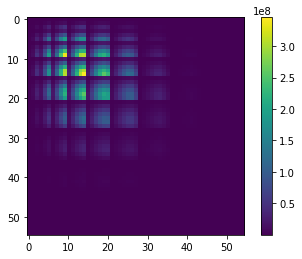

In [1182]:
%matplotlib inline

# visualize covariance matrix
plt.imshow(C)
plt.colorbar()

In [1183]:
# check that covariance is well-estimated
eigs,evecs = np.linalg.eig(C)
print('minimum eigenvalue', np.min(eigs))
print('maximum eigenvalue', np.max(eigs))

minimum eigenvalue 1.694772225007077
maximum eigenvalue 2166884968.5033126


# fisher calculation
We calculate the fisher for the 2PCF, $\xi_0$, as: 
$$ F_{ij} = \frac{1}{2} {\rm Tr} \left[ \boldsymbol{C}^{-1} \left[ \left( \frac{\partial \xi_0}{\partial \theta_i} \frac{\partial \xi_0}{\partial \theta_j}^T \right) + \left( \frac{\partial \xi_0}{\partial \theta_i}^T \frac{\partial \xi_0}{\partial \theta_j} \right) \right]  \right] $$
where the derivatives are approximated via
$$ \frac{\partial \xi_0}{\partial \theta_i} \approx \frac{\xi_0(\theta^+_i) - \xi_0(\theta^-_i)}{\theta^+_i - \theta^-_i} $$

In [1184]:
_dervs.shape

(2, 55)

In [1185]:
invC.shape

(55, 55)

In [1186]:
F = np.einsum("ij,jl,kl->ik", _dervs, invC, _dervs)

In [1187]:
F

array([[ 2213.93569083, -2322.13144042],
       [-2322.13144042,  2926.04887873]])

In [1188]:
np.linalg.inv(F)

array([[0.00269486, 0.00213866],
       [0.00213866, 0.00203901]])

In [1189]:
np.linalg.det(F)

1085789.6191341244

In [1190]:
from decimal import Decimal

print('det F: %.2E' % Decimal(str((np.linalg.det(F)))))
print('shannon entropy in nats: %.3f'%(0.5*np.log(np.linalg.det(F))))

det F: 1.09E+06
shannon entropy in nats: 6.949


# plot fisher forecasts

In [1191]:
import imnn.lfi
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [1192]:
lo = [0.1, 0.50]
hi = [0.5, 0.98]

prior = tfp.distributions.Blockwise(
    [tfp.distributions.Uniform(low=low, high=high)
     for low, high in zip(lo, hi)])
prior.low = np.array(lo)
prior.high = np.array(hi)

In [1193]:
F_2PCF = F #np.array(([[ 2275.48905284, -2304.95181558],
       #[-2304.95181558,  2976.81677819]]))

compare to some IMNN Fishers

In [1198]:
IMNN_decorate = np.array([[ 3501.2188,  7853.18  ],
             [ 7853.1807, 35320.02  ]])

In [1199]:
IMNN_no_decorate = np.array([[ 3051.3962,  6715.81  ],
             [ 6715.81  , 23282.832 ]])

In [1200]:
θ_fid = np.array([0.3175, 0.834])

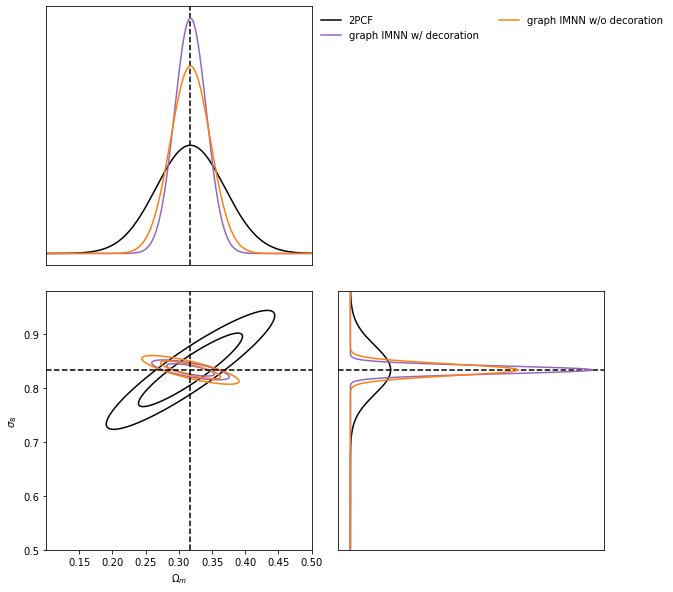

In [1201]:
GA1 = imnn.lfi.GaussianApproximation(
    parameter_estimates=θ_fid,#IMNN.get_estimate(target_data),
    invF=np.expand_dims(np.linalg.inv(F_2PCF), 0),
    prior=prior,
    
    gridsize=500)
ax = GA1.marginal_plot(
    known=θ_fid,
    label="2PCF",
    axis_labels=["$\Omega_m$", "$\sigma_8$"],
    colours="k", linestyle='-');


GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=θ_fid,
    invF=np.expand_dims(np.linalg.inv(IMNN_decorate), 0),
    prior=prior,
    gridsize=400)

GA.marginal_plot(
    ax=ax,
    #known=θ_fid,
    label="graph IMNN w/ decoration",
    axis_labels=["$\Omega_m$", "$\sigma_8$"],
    colours="C4");


GA = imnn.lfi.GaussianApproximation(
    parameter_estimates=θ_fid,
    invF=np.expand_dims(np.linalg.inv(IMNN_no_decorate), 0),
    prior=prior,
    gridsize=400)

GA.marginal_plot(
    ax=ax,
    #known=θ_fid,
    label="graph IMNN w/o decoration",
    axis_labels=["$\Omega_m$", "$\sigma_8$"],
    colours="C1");


plt.show()